<center> <h1>Module 7 - Logistic Regression </h1> </center>
<center> <h2>Class Coding Analysis</h2> </center>

In [44]:
# load packages here
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

# set seed
import random
random.seed(5600)

## Data and Description

Coronary heart disease (CHD) refers to a narrowing of the coronary arteries, the blood vessels that supply oxygen and blood to the heart. It is also known as coronary artery disease. It is a major cause of illness and death. CHD normally happens when cholesterol accumulates on the artery walls, creating plaques. The arteries narrow, reducing blood flow to the heart. Sometimes, a clot can obstruct the flow of blood to the heart muscle. CHD commonly causes angina pectoris (chest pain), shortness of breath, myocardial infarction, or a heart attack. It is the most common type of heart disease in the United States, where it accounts for 370,000 deaths every year.

The CHD data set contains information on 757 subjects (randomly selected) aged 39 to 59 years old and free of heart disease as determined by electrocardiogram at an initial screening. At baseline the variables in the following table were collected. Follow-up continued for 8.5 years with repeat examinations to determine if patients developed CHD. The goal is to determine risk factors (ways of healthy living) to avoid CHD.

Variable | Description
-------- | -------------
age      | Age in years
height   | Height in inches
weight   | Weight in pounds
sbp      | Systolic blood pressure in mmHg (millimeters of mercury)
dbp      | Diastolic blood pressure in mmHg (millimeters of mercury) 
chol     | Cholesterol in mg/dL (milligrams of cholesterol per deciliter of blood)
cigs     | Number of cigarettes smoked a day

Do the following:

1. Download the "CHD.csv" file from Canvas and put it in the same folder as this file.
2. Read in the data set and call it "chd".

In [45]:
chd = pd.read_csv("CHD.csv")
chd.head()

,age,height,weight,sbp,dbp,chol,cigs,chd
0,59,70,150,144,86,255,20,yes
1,50,72,173,144,90,238,50,yes
2,45,67,168,124,80,220,9,yes
3,54,72,185,130,80,274,40,yes
4,54,65,150,122,88,307,0,yes


## Explore the Data (EDA)

### Explore the distribution of the response.

In [3]:
chd['chd'].value_counts()

no     500
yes    257
Name: chd, dtype: int64

### Create a scatterplot matrix (using the continuous variables only).

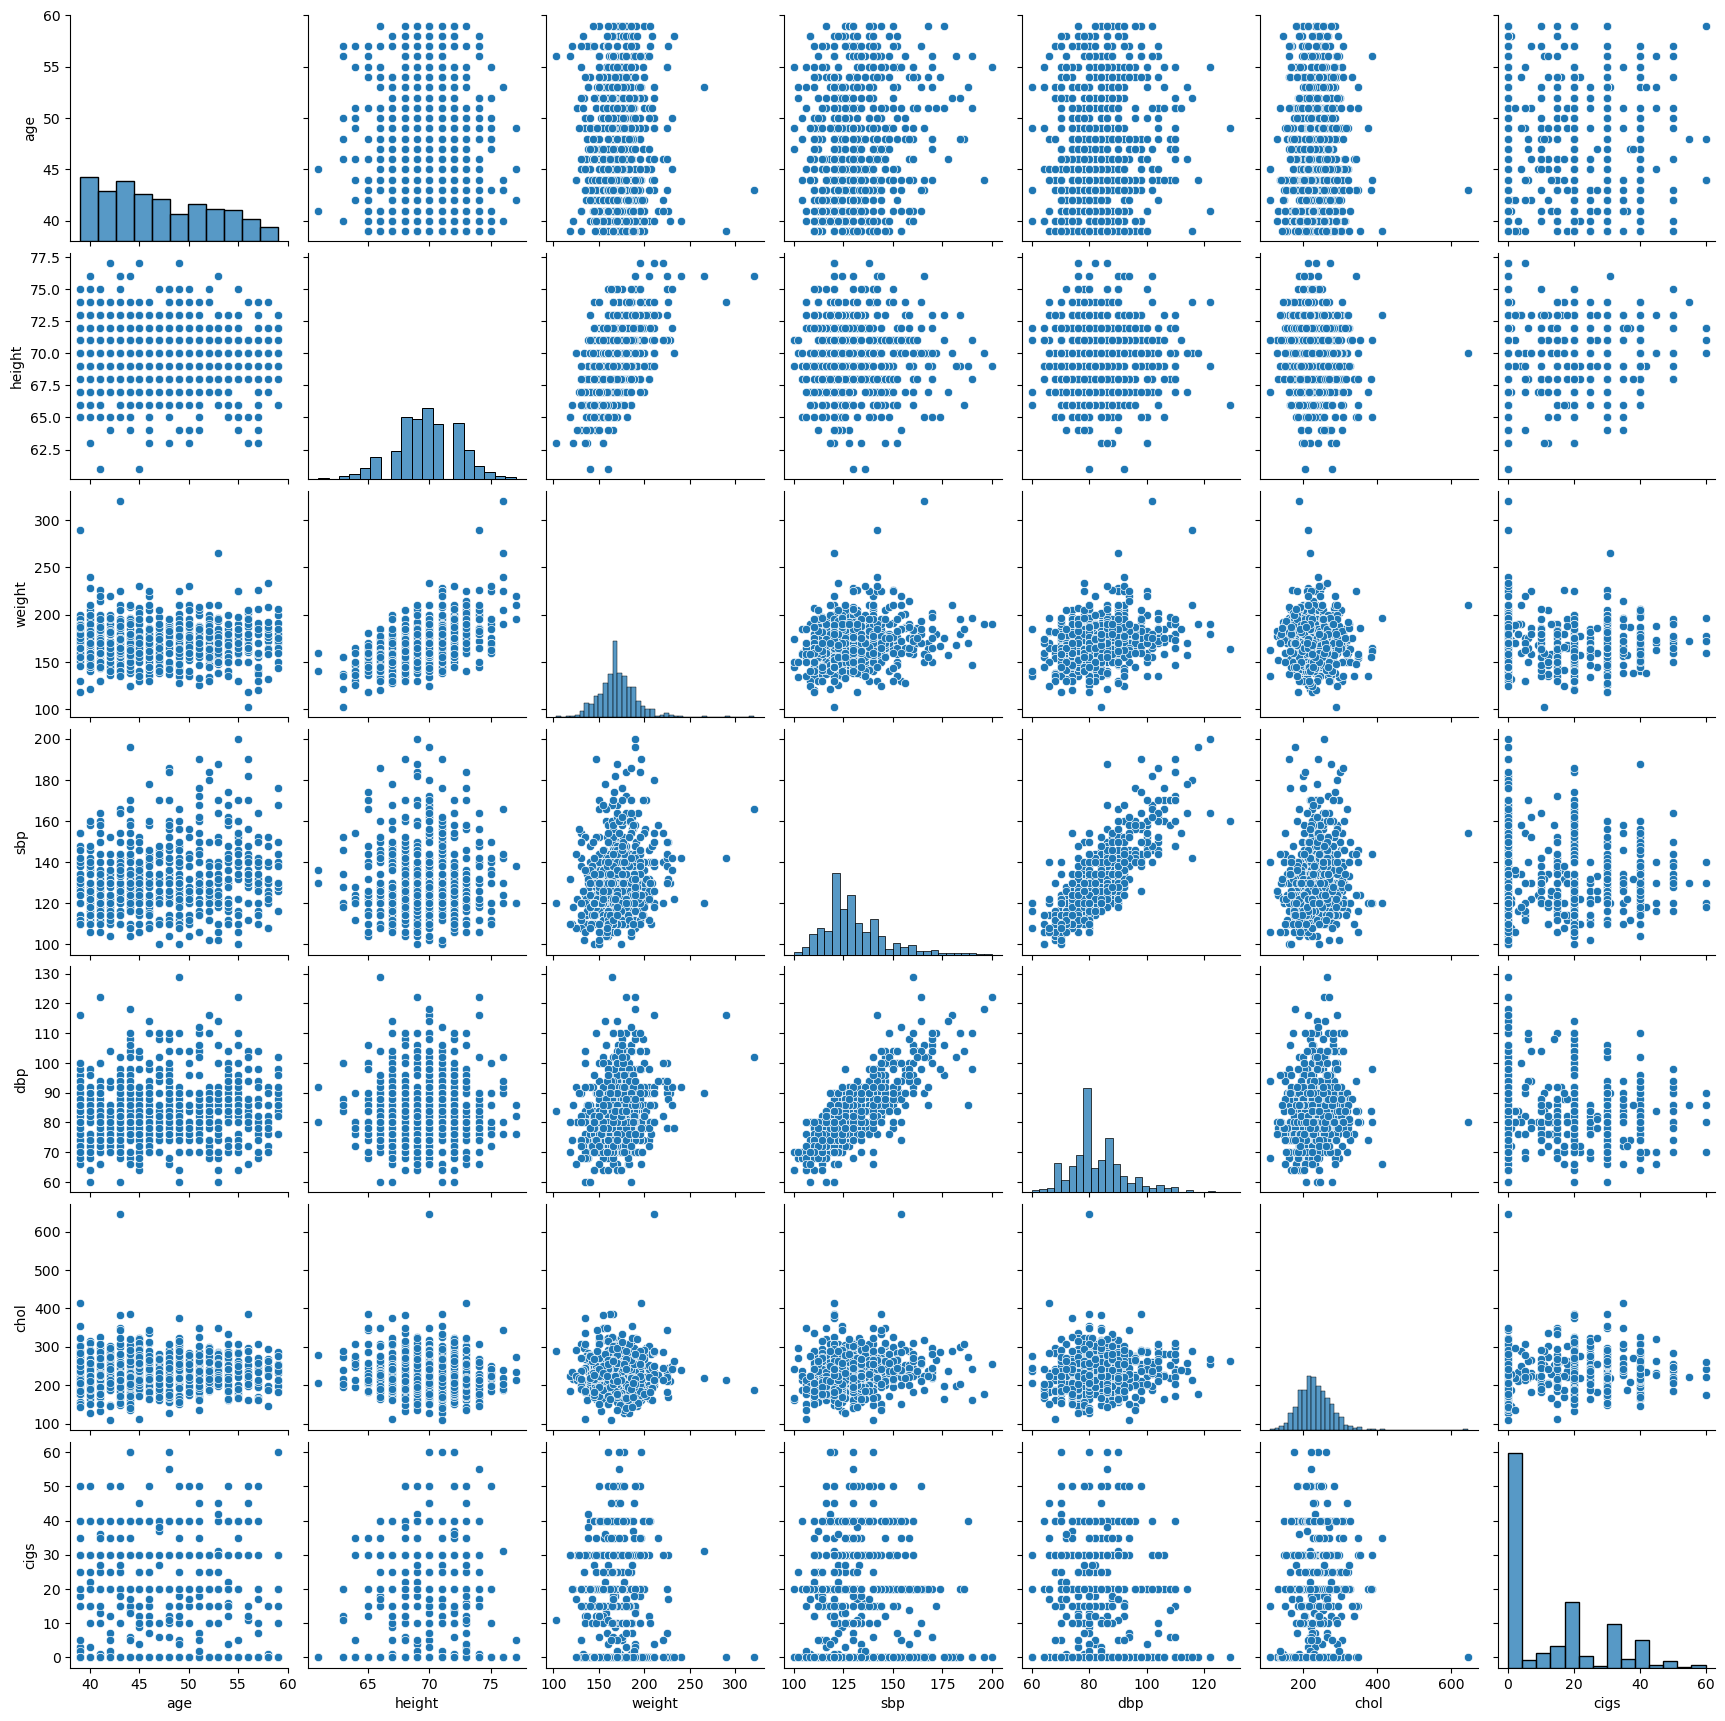

In [4]:
sns.pairplot(chd)

### Create a color-coded correlation matrix

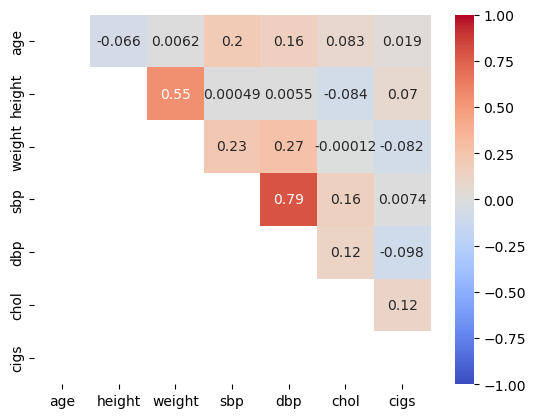

In [5]:
sns.heatmap(chd.corr(numeric_only = True), 
            cmap = 'coolwarm', 
            annot = True, 
            vmin = -1,
            vmax = 1,
            mask = np.tril(chd.corr(numeric_only = True)))
plt.show()

### Create a boxplot of Age by CHD status

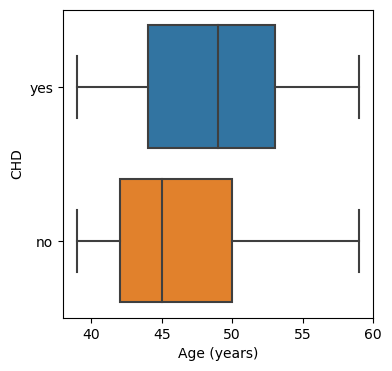

In [6]:
plt.figure(figsize = (4, 4))
sns.boxplot(x = 'age', 
            y = 'chd', 
            data = chd)
plt.xlabel('Age (years)')
plt.ylabel('CHD')
plt.show()

### Create a color-coded scatterplot of Chol vs Weight colored by CHD.

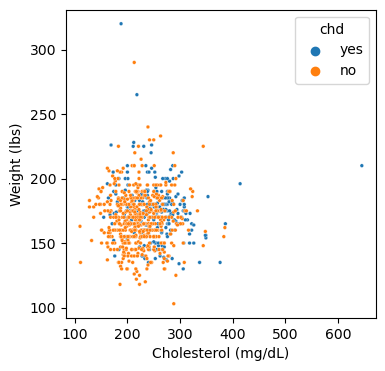

In [7]:
plt.figure(figsize = (4, 4))
sns.scatterplot(data = chd, 
                x = 'chol', 
                y = 'weight', 
                hue = 'chd',
                s = 7)
plt.xlabel('Cholesterol (mg/dL)')
plt.ylabel('Weight (lbs)')
plt.show()

### Create a Contingency Table of CHD and Age

In [8]:
print(pd.crosstab(chd['age'], 
                  chd['chd'],  
                  margins = True))

chd   no  yes  All
age               
39    32   19   51
40    50   12   62
41    38   12   50
42    33    5   38
43    43   13   56
44    38   13   51
45    26   12   38
46    34   11   45
47    23    8   31
48    24   19   43
49    27   21   48
50    18   11   29
51    20   17   37
52    13   15   28
53    17   12   29
54    20   11   31
55    14   10   24
56    11   12   23
57    10    7   17
58     7    6   13
59     2   11   13
All  500  257  757


## Split the Data Set into Train and Test Sets

In [46]:
# convert the response to 1/0 instead of yes/no
chd['chd'] = np.where(chd['chd'] == 'yes', 1, 0)
chd.head()

,age,height,weight,sbp,dbp,chol,cigs,chd
0,59,70,150,144,86,255,20,1
1,50,72,173,144,90,238,50,1
2,45,67,168,124,80,220,9,1
3,54,72,185,130,80,274,40,1
4,54,65,150,122,88,307,0,1


In [47]:
y = chd['chd']
X = chd.drop('chd', axis = 1)
y.value_counts()

0    500
1    257
Name: chd, dtype: int64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5600)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(605, 7) (605,)
(152, 7) (152,)


## Perform Variable Selection

### Best Subsets

In [49]:
best_subsets_selection = EFS(LogisticRegression(fit_intercept = True,
                                                max_iter = 1000,
                                                penalty = None),  # THIS IS NOT IN THE VIDEO, BUT IT SHOULD BE
                             min_features = 1,
                             max_features = len(X_train.columns),
                             scoring = 'accuracy',  # Options: accuracy, f1, precision, recall, roc_auc
                             print_progress = False,
                             cv = 10)

best_subsets = best_subsets_selection.fit(X_train, y_train)

print('Best subset:', best_subsets.best_feature_names_)

Best subset: ('age', 'height', 'sbp', 'chol', 'cigs')


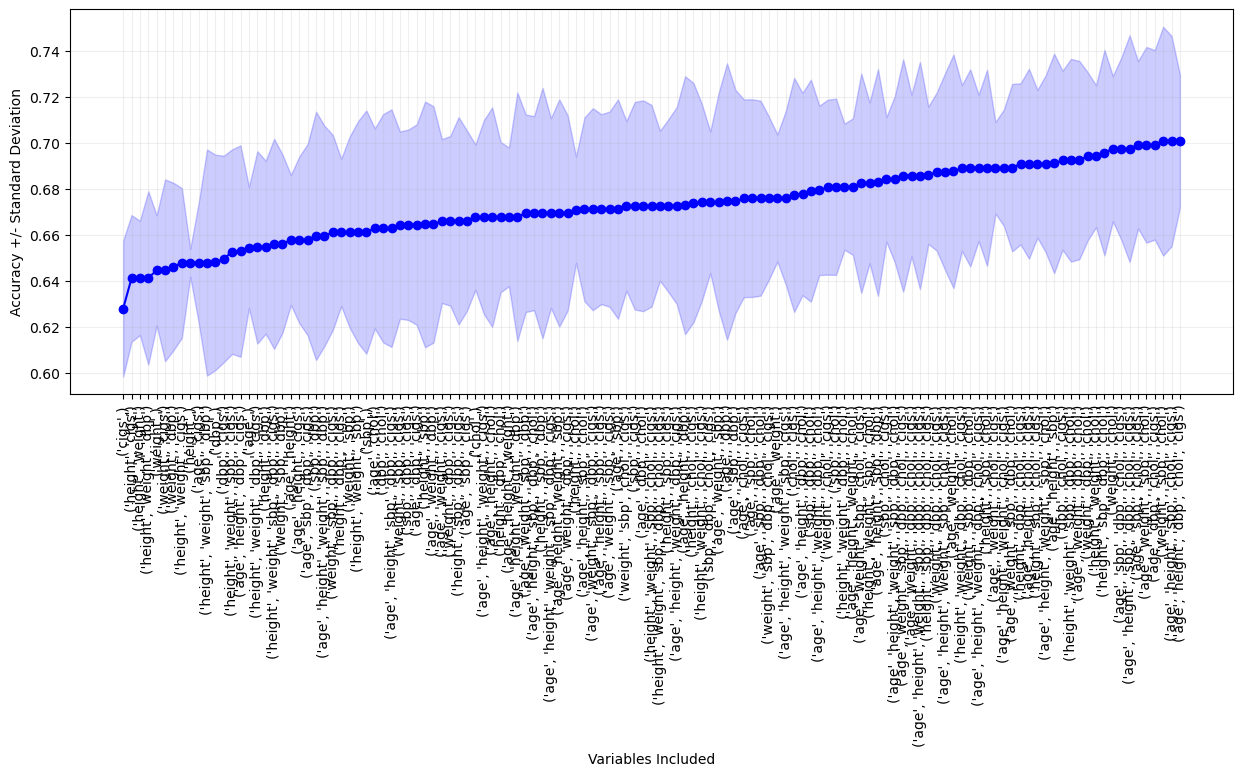

In [50]:
metric_dict = best_subsets_selection.get_metric_dict()
x_axis = sorted(metric_dict.keys())

metric_dict_sorted = dict(sorted(metric_dict.items(), key = lambda x: x[1]['avg_score']))

fig = plt.figure(figsize = (15, 5))
k_feat = metric_dict_sorted.keys()
k_feat_list = list(k_feat)
avg = [metric_dict_sorted[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict_sorted[k]['avg_score'] +
                 metric_dict_sorted[k]['std_dev'])
    lower.append(metric_dict_sorted[k]['avg_score'] -
                 metric_dict_sorted[k]['std_dev'])
    
plt.fill_between(x_axis,
                 upper,
                 lower,
                 alpha = 0.2,
                 color = 'blue',
                 lw = 1)

plt.plot(x_axis, avg, color = 'blue', marker = 'o')
plt.ylabel('Accuracy +/- Standard Deviation')
plt.xlabel('Variables Included')
plt.xticks(x_axis, 
           [str(metric_dict_sorted[k]['feature_names']) for k in k_feat_list], 
           rotation = 90)
plt.grid(alpha = 0.2)
plt.show()

In [51]:
# Code to see the next best models
best_subsets_results = pd.DataFrame.from_dict(best_subsets_selection.get_metric_dict()).T
best_subsets_results_sorted = best_subsets_results.sort_values(by = 'avg_score', ascending = False)
best_subsets_results_sorted.head(5)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
106,"(0, 1, 3, 5, 6)","[0.8032786885245902, 0.6885245901639344, 0.688...",0.70082,"(age, height, sbp, chol, cigs)",0.03391,0.045656,0.015219
107,"(0, 1, 4, 5, 6)","[0.7540983606557377, 0.7213114754098361, 0.704...",0.70082,"(age, height, dbp, chol, cigs)",0.021423,0.028845,0.009615
54,"(2, 3, 5)","[0.7540983606557377, 0.7213114754098361, 0.786...",0.700792,"(weight, sbp, chol)",0.036917,0.049705,0.016568
74,"(0, 2, 3, 5)","[0.7049180327868853, 0.7704918032786885, 0.721...",0.699208,"(age, weight, sbp, chol)",0.031562,0.042496,0.014165
82,"(0, 4, 5, 6)","[0.7704918032786885, 0.7213114754098361, 0.704...",0.699208,"(age, dbp, chol, cigs)",0.030576,0.041168,0.013723


### Fit a Logistic Regression Model on the Training Data with the Variables Chosen Previously

In [15]:
y_train.value_counts()

0    392
1    213
Name: chd, dtype: int64

In [52]:
X_train_subset = sm.add_constant(X_train[['age', 'weight', 'sbp', 'chol', 'cigs']])
mod = sm.Logit(y_train, X_train_subset)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.554881
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  605
Model:                          Logit   Df Residuals:                      599
Method:                           MLE   Df Model:                            5
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                  0.1446
Time:                        17:15:25   Log-Likelihood:                -335.70
converged:                       True   LL-Null:                       -392.47
Covariance Type:            nonrobust   LLR p-value:                 7.312e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7071      1.426     -8.914      0.000     -15.501      -9.913
age            0.0596      0.017      3.498      0.000       0.026       0.093
weight         0.0175      0.005      3.889      0.000       0.009       0.026
sbp            0.0204      0.006      3.332      0.001       0.008       0.032
chol           0.0138      0.002      5.931      0.000       0.009       0.018
cigs           0.0245      0.006      3.970      0.000       0.012       0.037
==============================================================================
"""

### Check Model Assumptions

#### The X's vs log odds are linear (monotone in probability) (Use scatterplots with smoothers - `sm.nonparametric.lowess`)

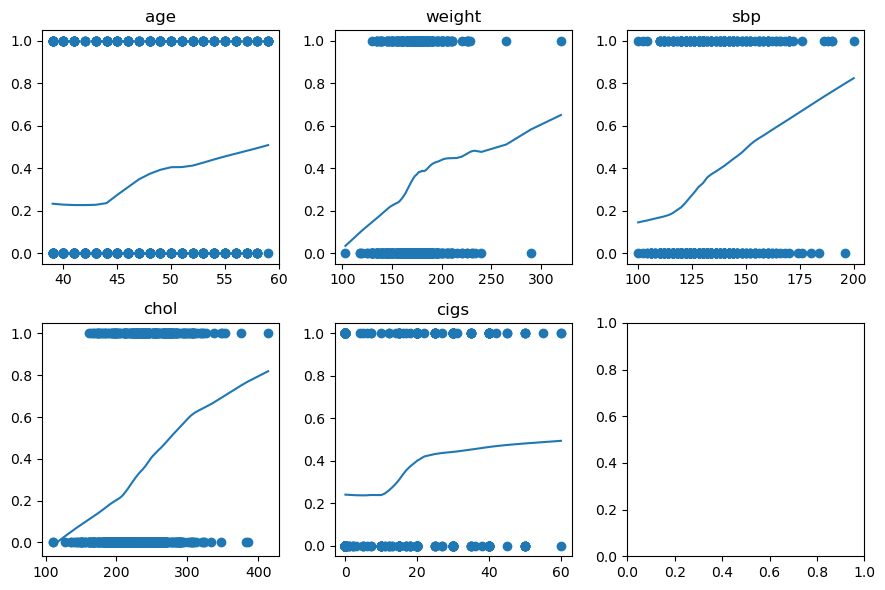

In [17]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

out = sm.nonparametric.lowess(y_train, X_train_subset['age'])
ax[0, 0].scatter(y = y_train, x = X_train_subset['age'])
ax[0, 0].plot(out[:, 0], out[:, 1])
ax[0, 0].set_title("age")

out = sm.nonparametric.lowess(y_train, X_train_subset['weight'])
ax[0, 1].scatter(y = y_train, x = X_train_subset['weight'])
ax[0, 1].plot(out[:, 0], out[:, 1])
ax[0, 1].set_title("weight")

out = sm.nonparametric.lowess(y_train, X_train_subset['sbp'])
ax[0, 2].scatter(y = y_train, x = X_train_subset['sbp'])
ax[0, 2].plot(out[:, 0], out[:, 1])
ax[0, 2].set_title("sbp")

out = sm.nonparametric.lowess(y_train, X_train_subset['chol'])
ax[1, 0].scatter(y = y_train, x = X_train_subset['chol'])
ax[1, 0].plot(out[:, 0], out[:, 1])
ax[1, 0].set_title("chol")

out = sm.nonparametric.lowess(y_train, X_train_subset['cigs'])
ax[1, 1].scatter(y = y_train, x = X_train_subset['cigs'])
ax[1, 1].plot(out[:, 0], out[:, 1])
ax[1, 1].set_title("cigs")

plt.tight_layout()
plt.show()

In [37]:
# list(X_train_subset.columns[1:6])

['age', 'weight', 'sbp', 'chol', 'cigs']

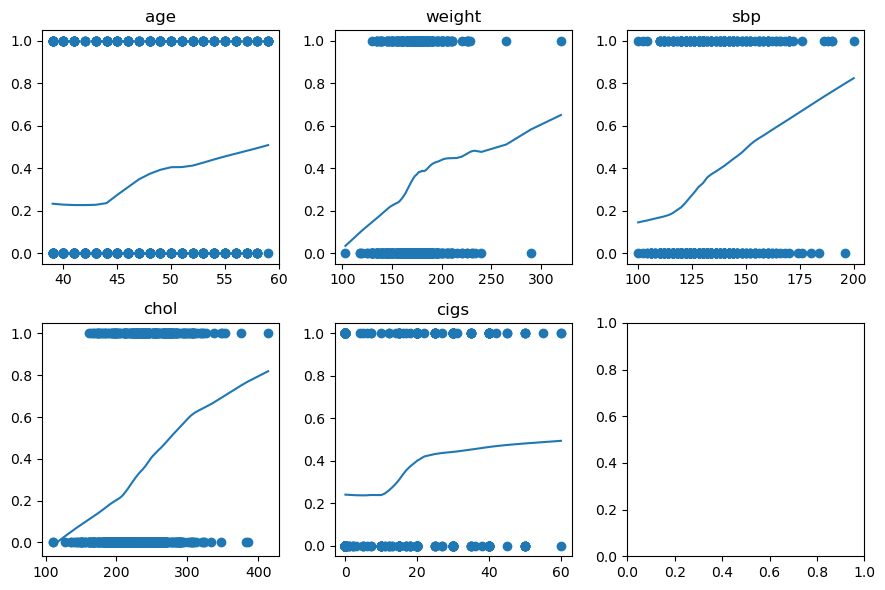

In [41]:
# def scatterplot_with_smoother(ax, y, x, title):
#     smoothed = sm.nonparametric.lowess(y, x)
#     ax.scatter(y = y, x = x)
#     ax.plot(smoothed[:, 0], smoothed[:, 1])
#     ax.set_title(title)

# fig, ax = plt.subplots(2, 3, figsize = (9, 6))
# variables = list(X_train_subset.columns[1:6])

# # Plot each variable
# for i, var in enumerate(variables):
#     scatterplot_with_smoother(ax[i // 3, i % 3], 
#                               y_train, 
#                               X_train_subset[var],
#                               variables[i])
# plt.tight_layout()
# plt.show()

#### The model describes all observations (i.e., there are no influential points)

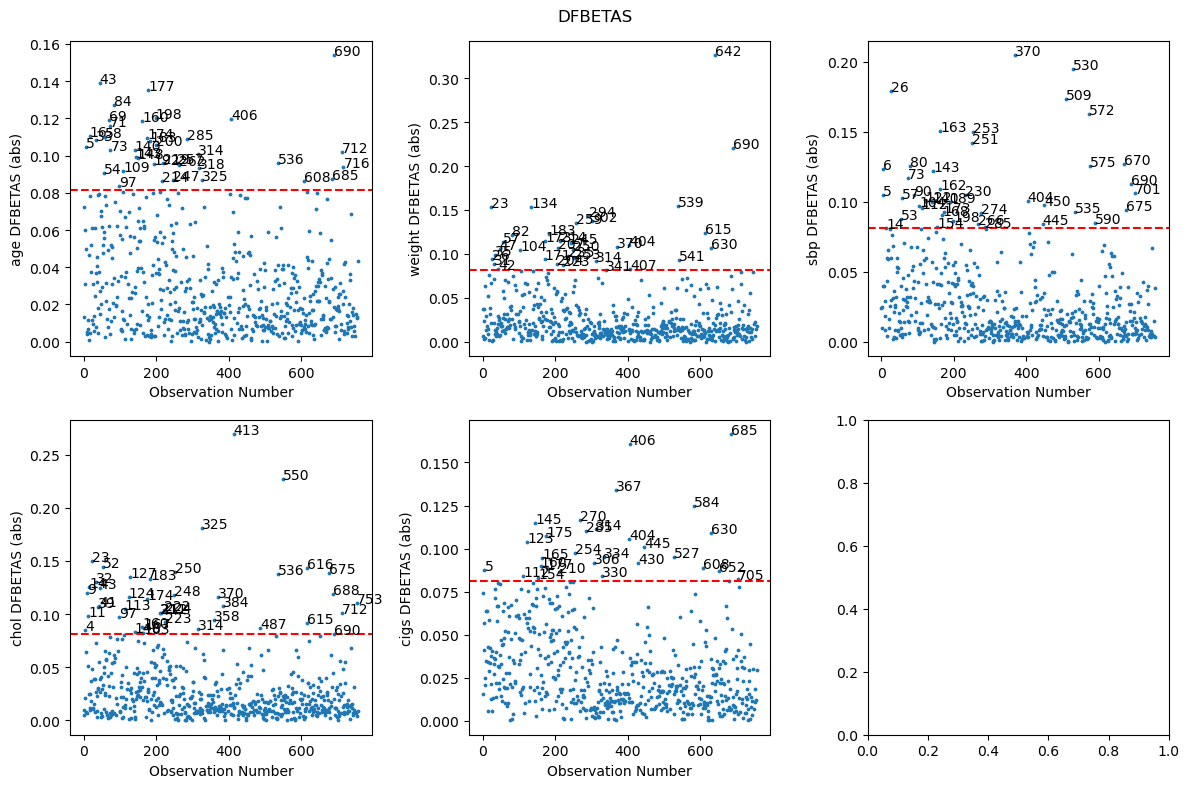

In [18]:
# DFBETAS
def plot_dfbetas(column, ax, label_level = 2 / np.sqrt(len(X_train_subset))):
    idx = X_train_subset.columns.get_loc(column)
    X_train_subset['dfbetas_' + column] = res.get_influence().dfbetas[:, idx]

    ax.set_ylabel(column + " DFBETAS (abs)")
    ax.set_xlabel("Observation Number")
    ax.scatter(X_train_subset.index, np.abs(X_train_subset['dfbetas_' + column]), s = 3)
    ax.axhline(y = label_level, color = 'r', linestyle = 'dashed')

    # optional: label outliers
    outliers = X_train_subset[np.abs(X_train_subset['dfbetas_' + column]) > label_level]
    for i in list(outliers.index):
        ax.annotate(str(i), (i, np.abs(X_train_subset['dfbetas_' + column][i])))
    
fig, axes = plt.subplots(2, 3, figsize = (12, 8))
plt.suptitle("DFBETAS")
plot_dfbetas("age", axes[0, 0])
plot_dfbetas("weight", axes[0, 1])
plot_dfbetas("sbp", axes[0, 2])
plot_dfbetas("chol", axes[1, 0])
plot_dfbetas("cigs", axes[1, 1])
fig.tight_layout()
plt.show()

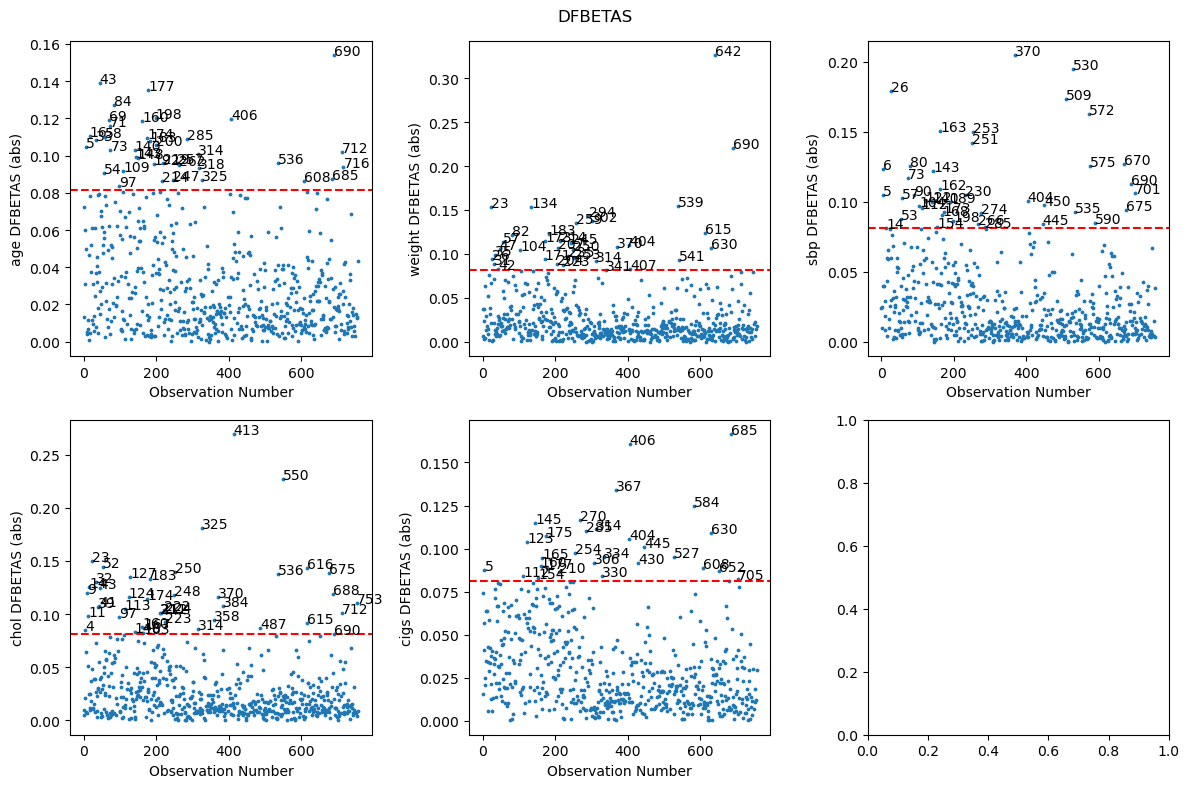

In [43]:
# # DFBETAS
# def plot_dfbetas(column, ax, label_level = 2 / np.sqrt(len(X_train_subset))):
#     idx = X_train_subset.columns.get_loc(column)
#     X_train_subset['dfbetas_' + column] = res.get_influence().dfbetas[:, idx]

#     ax.set_ylabel(column + " DFBETAS (abs)")
#     ax.set_xlabel("Observation Number")
#     ax.scatter(X_train_subset.index, np.abs(X_train_subset['dfbetas_' + column]), s = 3)
#     ax.axhline(y = label_level, color = 'r', linestyle = 'dashed')

#     # optional: label outliers
#     outliers = X_train_subset[np.abs(X_train_subset['dfbetas_' + column]) > label_level]
#     for i in list(outliers.index):
#         ax.annotate(str(i), (i, np.abs(X_train_subset['dfbetas_' + column][i])))
    
    
# fig, axes = plt.subplots(2, 3, figsize = (12, 8))
# plt.suptitle("DFBETAS")
# variable_names = list(X_train_subset.columns[1:6])

# for i, var in enumerate(variable_names):
#     plot_dfbetas(var, axes[i // 3, i % 3])
# fig.tight_layout()
# plt.show()

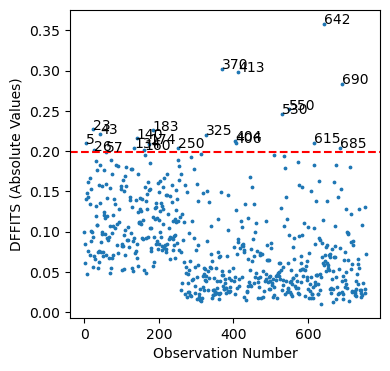

In [19]:
# DFFITS
X_train_subset['dffits'] = res.get_influence().summary_frame()['dffits_internal']

# plot DFFITS against the observation number
fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFFITS (Absolute Values)")
plt.xlabel("Observation Number")
plt.scatter(X_train_subset.index, np.abs(X_train_subset['dffits']), s = 3)
plt.axhline(y = 2 * np.sqrt(len(res.params) / len(X_train_subset)), color = 'r', linestyle = 'dashed')

#OPTIONAL: code to grab potential outliers
outliers = X_train_subset[np.abs(X_train_subset['dffits']) > 2 * np.sqrt(len(res.params) / len(X_train_subset))]
for i in list(outliers.index):
        plt.annotate(str(i), (i, np.abs(X_train_subset['dffits'][i])))
plt.show()

#### No Multicollinearity

In [20]:
chd_logistic_vifs = pd.DataFrame()
chd_logistic_vifs['Feature'] = X_train_subset.columns[1:6]
chd_logistic_vifs['VIF'] = [vif(X_train_subset, i) for i in range(1, len(X_train_subset.columns[0:6]))]

print("Max = ", max(chd_logistic_vifs['VIF']))
print("Mean = ", np.mean(chd_logistic_vifs['VIF']))
chd_logistic_vifs

Max =  1.1336249031208825
Mean =  1.0754576006959207


,Feature,VIF
0,age,1.052231
1,weight,1.091343
2,sbp,1.133625
3,chol,1.060274
4,cigs,1.039816


### Convert the coefficient of age from a log odds ratio to an odds ratio to a percentage

In [21]:
# log odds ratio: 
lor = res.params['age']
print(lor)

# odds ratio:
print(np.exp(lor))

# odds ratio converted to a percentage
print(100 * (np.exp(lor) - 1))

0.059582653636143464
1.061393485385062
6.139348538506195


### Calculate a 95% confidence interval for the predicted **log odds** that a patient has CHD for a patient where age = 50, weight = 182, sbp = 136, chol = 253, and cigs = 20.

In [22]:
pred = res.get_prediction([1, 50, 182, 136, 253, 20], which = 'linear')
pred.summary_frame(alpha = 0.05)

,predicted,se,ci_lower,ci_upper
0,0.210131,0.125019,-0.034903,0.455164


### Calculate a 95% confidence interval for the predicted **probability** that a patient has CHD for a patient where age = 50, weight = 182, sbp = 136, chol = 253, and cigs = 20.

In [23]:
pred = res.get_prediction([1, 50, 182, 136, 253, 20])
pred.summary_frame(alpha = 0.05)

,predicted,se,ci_lower,ci_upper
0,0.55234,0.030912,0.491275,0.611866


### Find the cutoff value that minimizes the percent misclassified

In [24]:
possible_cutoffs = np.linspace(0, 1, 100)
percent_misclass = np.ones(100)
predicted_probabilities = np.exp(res.fittedvalues) / (1 + np.exp(res.fittedvalues))
    
for i in range(len(possible_cutoffs) - 1):
  cutoff = possible_cutoffs[i]
  classify = (predicted_probabilities > cutoff).astype(int)
  percent_misclass[i] = np.mean((classify != y_train.astype(int)).astype(int))

cutoff = possible_cutoffs[np.argmin(percent_misclass)]
cutoff

0.4747474747474748

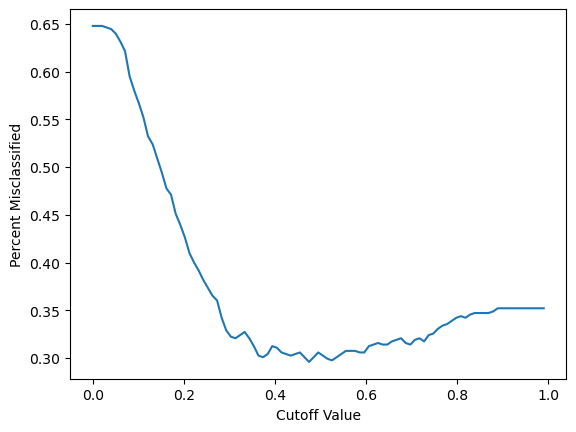

In [25]:
plt.plot(possible_cutoffs[:-1], percent_misclass[:-1])
plt.xlabel('Cutoff Value')
plt.ylabel('Percent Misclassified')
plt.show()

### Plot the ROC curve and obtain the AUC

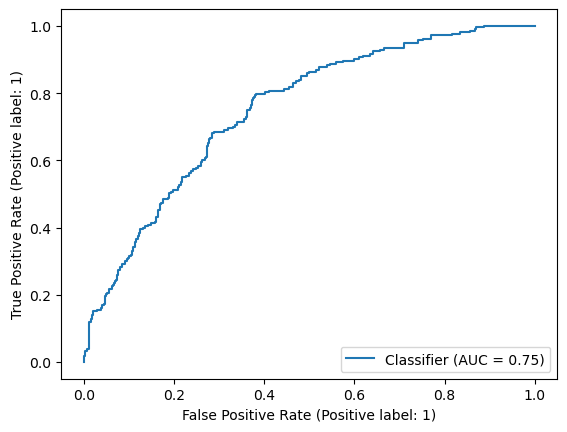

0.7507185972980741

In [26]:
RocCurveDisplay.from_predictions(y_train, predicted_probabilities)
plt.show()
roc_auc_score(y_train, predicted_probabilities)

### Create a confusion matrix FOR THE TEST DATA SET using the best cutoff value you found above.

In [27]:
# Get predicted probabilities for the test data set
X_test_subset = sm.add_constant(X_test[['age', 'weight', 'sbp', 'chol', 'cigs']])
pred_probs_test = res.predict(X_test_subset)

In [28]:
# Use the cutoff to get predicted classifications of 0/1
preds_test = (pred_probs_test > cutoff).astype(int)
# Get confusion matrix
conf_mat = confusion_matrix(y_test, preds_test)
conf_mat

array([[95, 13],
       [25, 19]], dtype=int64)

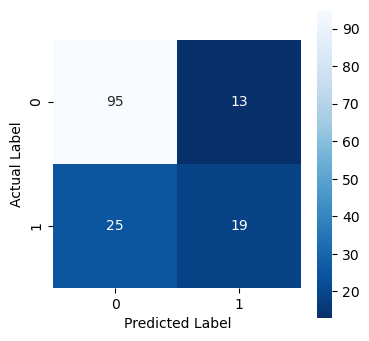

In [29]:
# Confusion matrix with labels
plt.figure(figsize = (4, 4))
sns.heatmap(conf_mat, 
            annot = True, 
            fmt = ".0f", 
            square = True, 
            cmap = 'Blues_r')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Obtain the AUC FOR THE TEST DATA

In [30]:
roc_auc_score(y_test, pred_probs_test)

0.7571548821548822

## Summary and Conclusions

Logistic regression is used when you have a binary response variable. Many of the things we learned for linear regression apply to logistic regression, but there are several differences. For instance, we have fewer model assumptions, we measure performance based on deviances (instead of sums of squares), the coefficients are in terms of log odds ratios, and we can perform classification. 